In [1]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user

In [2]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import sklearn
import time
import os
os.environ['SPARK_HOME'] = "/content/spark-3.1.2-bin-hadoop3.2"
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, StandardScalerModel
from pyspark.ml.feature import Imputer
from numpy.core.fromnumeric import mean
from pyspark import SparkFiles
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import isnan, when, count, col, avg
plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('stroke_prediction').getOrCreate()
except NameError:
    spark = SparkSession.builder.appName('stroke_prediction').getOrCreate()

sqlContext=SQLContext(spark)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
url = ('https://github.com/GouthamJagadeesha/BDA_Technical_Project_L00157174/blob/main/healthcare-dataset-stroke-data.csv?raw=true')

In [6]:
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), header=True, inferSchema=True)
df = df.drop('id')
df.show()

# extracting number of rows from the Dataframe
row = df.count()

# extracting number of columns from the Dataframe
col = len(df.columns)
 
# printing
print(f'Dimension of the Dataframe is: {(row,col)}')
print(f'Number of Rows are: {row}')
print(f'Number of Columns are: {col}')

df.printSchema()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.

In [7]:
cols = df.columns

In [8]:
numericCols = [field.name for field in df.schema.fields if isinstance(field.dataType, IntegerType) or isinstance(field.dataType, DoubleType)]
numericCols

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke']

In [9]:
categoricalColumns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
categoricalColumns

['gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'bmi',
 'smoking_status']

In [10]:
data=pd.read_csv(url)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [11]:
#Checking null value sum
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
null_list = ['not_set', 'n/a', 'N/A']
from pyspark.sql.functions import col    
df =  df.withColumn(
    "bmi",
    when(
        col("bmi").isin(null_list),
        None
    ).otherwise(col("bmi"))
)
#filling mean values to column
df = df.withColumn("bmi", df["bmi"].cast(IntegerType()))
df.describe('bmi').show()
imputer = Imputer(
    inputCols=['bmi'], 
    outputCols=["{}_imputed".format(c) for c in ['bmi']]
).setStrategy("mean")

# Adding imputation cols to df
df = imputer.fit(df).transform(df)

columns_to_drop = ['id', 'bmi']
df = df.drop(*columns_to_drop)
df = df.withColumnRenamed("bmi_imputed","bmi")
df.show()

+-------+------------------+
|summary|               bmi|
+-------+------------------+
|  count|              4909|
|   mean|28.448563862293746|
| stddev| 7.843833618220339|
|    min|                10|
|    max|                97|
+-------+------------------+

+------+----+------------+-------------+------------+-------------+--------------+-----------------+---------------+------+---+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| smoking_status|stroke|bmi|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+---------------+------+---+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|formerly smoked|     1| 36|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|   never smoked|     1| 28|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.9

In [13]:
categoricalColumns = ['gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'bmi',
 'smoking_status']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[ categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'stroke', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [14]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: integer (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [15]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
gender,Male,Female,Male,Female,Female
age,67.0,61.0,80.0,49.0,79.0
hypertension,0,0,0,0,1
heart_disease,1,0,1,0,0
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,228.69,202.21,105.92,171.23,174.12


In [16]:
train, test = df.randomSplit([0.7, 0.3], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3540
Test Dataset Count: 1570


In [17]:
#USING LOGISTIC REGRESSION MODEL

In [18]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

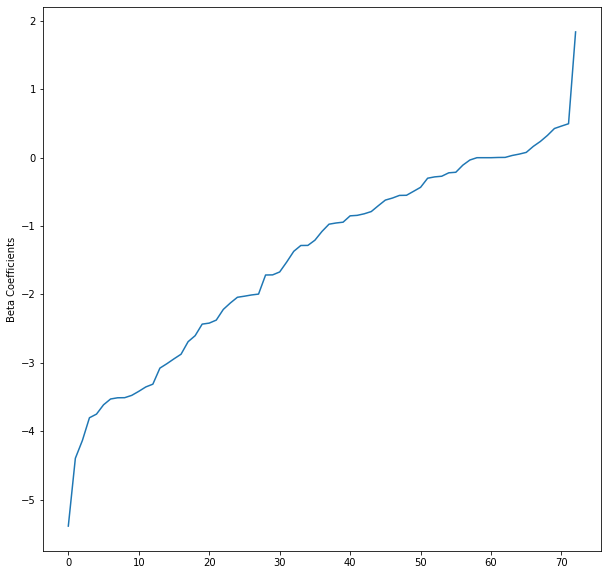

In [50]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


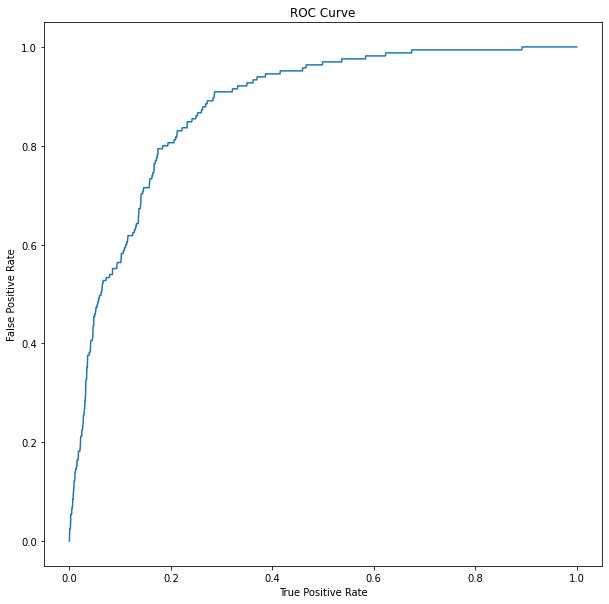

Training set areaUnderROC: 0.8780175084175006


In [20]:
LRtrainingSummary = lrModel.summary
roc = LRtrainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(LRtrainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


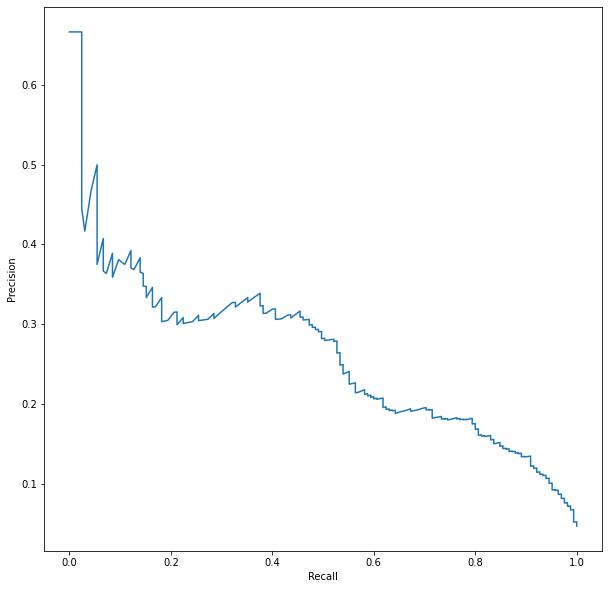

In [21]:
#Precision and recall.
pr = LRtrainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [48]:
#Making predictions on the test set.
LRpredictions = lrModel.transform(test)
LRpredictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[2.01111465905409...|       0.0|[0.88195911567691...|
|  0.0|[1.63588827597173...|       0.0|[0.83697467768070...|
|  0.0|[4.91613315918492...|       0.0|[0.99272589032023...|
|  0.0|[4.75644089770905...|       0.0|[0.99147711440639...|
|  0.0|[3.83752527121554...|       0.0|[0.97890761654250...|
|  0.0|[3.47066166869446...|       0.0|[0.96984137773222...|
|  0.0|[3.61023142893909...|       0.0|[0.97366661484887...|
|  0.0|[2.76261795157003...|       0.0|[0.94062202124624...|
|  0.0|[1.40514635200035...|       0.0|[0.80299926706709...|
|  0.0|[2.11970791702552...|       0.0|[0.89280397890943...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [51]:
#Evaluating our Logistic Regression model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
LR_accuracy = evaluator.evaluate(LRpredictions) * 100
print('Test Area Under ROC', evaluator.evaluate(LRpredictions))

Test Area Under ROC 0.7903047490867173


In [24]:
#USING DECISSION TREE CLASSIFIER

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
DTpredictions = dtModel.transform(test)
DTpredictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+-------------+----------+--------------------+
|label|rawPrediction|prediction|         probability|
+-----+-------------+----------+--------------------+
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0| [297.0,37.0]|       0.0|[0.88922155688622...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
|  0.0| [251.0,71.0]|       0.0|[0.77950310559006...|
|  0.0|[2827.0,56.0]|       0.0|[0.98057578910856...|
+-----+-------------+----------+--------------------+
only showing top 10 rows



In [26]:
evaluator = BinaryClassificationEvaluator()
DT_accuracy = evaluator.evaluate(DTpredictions) * 100
print("Test Area Under ROC: " + str(evaluator.evaluate(DTpredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5224355893097481


In [27]:
#Using Random forest Classifier

In [28]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
RFpredictions = rfModel.transform(test)
RFpredictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[18.4490321072190...|       0.0|[0.92245160536095...|
|  0.0|[18.2311413514775...|       0.0|[0.91155706757387...|
|  0.0|[19.0419231346861...|       0.0|[0.95209615673430...|
|  0.0|[19.0419231346861...|       0.0|[0.95209615673430...|
|  0.0|[19.0419231346861...|       0.0|[0.95209615673430...|
|  0.0|[18.6749692446001...|       0.0|[0.93374846223000...|
|  0.0|[19.0419231346861...|       0.0|[0.95209615673430...|
|  0.0|[19.0419231346861...|       0.0|[0.95209615673430...|
|  0.0|[18.9081864293105...|       0.0|[0.94540932146552...|
|  0.0|[18.4979753273372...|       0.0|[0.92489876636686...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [29]:
evaluator = BinaryClassificationEvaluator()
RF_accuracy = evaluator.evaluate(RFpredictions) * 100
print("Test Area Under ROC: " + str(evaluator.evaluate(RFpredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7714381849644297


In [30]:
#using Gradient-Boosted Tree Classifier

In [31]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
GBTpredictions = gbtModel.transform(test)
GBTpredictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.95285523649373...|       0.0|[0.87053647440099...|
|  0.0|[1.23320058757404...|       0.0|[0.92175259418296...|
|  0.0|[1.31916586586157...|       0.0|[0.93328817082177...|
|  0.0|[1.31916586586157...|       0.0|[0.93328817082177...|
|  0.0|[1.31179421304142...|       0.0|[0.93236434780668...|
|  0.0|[1.31179421304142...|       0.0|[0.93236434780668...|
|  0.0|[1.27496392182517...|       0.0|[0.92756866696116...|
|  0.0|[0.92645312162434...|       0.0|[0.86446796827526...|
|  0.0|[0.58760182981608...|       0.0|[0.76408431335037...|
|  0.0|[0.54088020994807...|       0.0|[0.74682698187456...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [32]:
evaluator = BinaryClassificationEvaluator()
GBT_accuracy = evaluator.evaluate(GBTpredictions) * 100
print("Test Area Under ROC: " + str(evaluator.evaluate(GBTpredictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.809792187399859


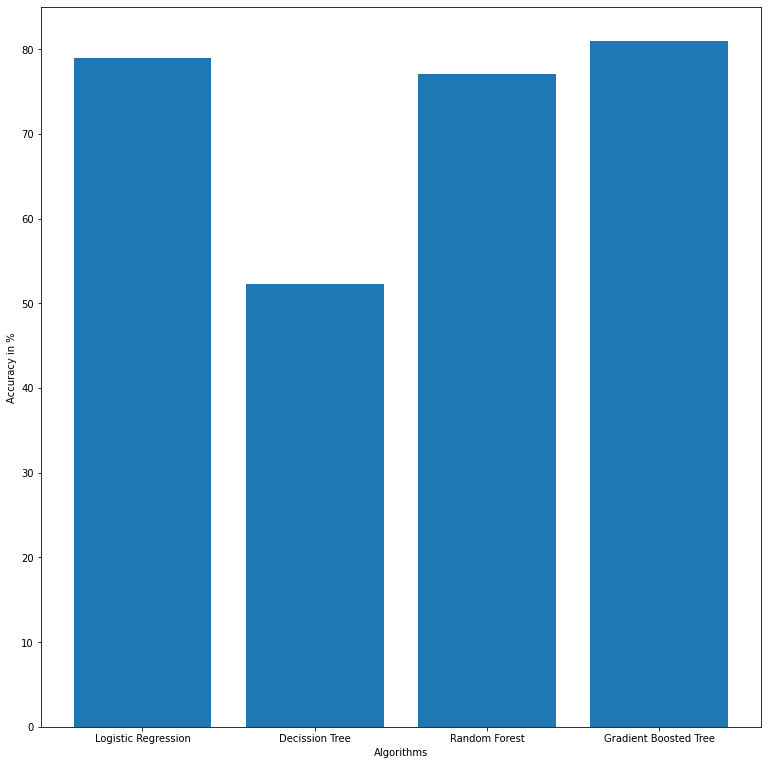

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xlabel('Algorithms')
plt.ylabel('Accuracy in %')
alg = ['Logistic Regression', 'Decission Tree', 'Random Forest', 'Gradient Boosted Tree']
acc = [LR_accuracy,DT_accuracy,RF_accuracy,GBT_accuracy]
ax.bar(alg,acc)
plt.show()